# Importing Necessary Libraries

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm

# Functions of y1 and y2 for checking y_loss

In [17]:
def f_y_1(x0, x1):
    return torch.sin(5 * x0 + 3 * x1)

def f_y_2(x0, x1):
    return torch.cos(4 * x0 + 8 * x1)

# Hyperparameters

In [2]:
number_of_points = 50
in_channels1 = 1
out_channels1 = 16
kernel_size1 = (16, 2) 
out_channels2 = 32
kernel_size2 = (8, 2)
out_channels3 = 64
kernel_size3 = (4, 2)
kernel_size4 = (16,2)
padding = (0, 1)
dimInt = (number_of_points-kernel_size1[0]+1-kernel_size2[0]+1-kernel_size3[0]+1)
latent_dim = 800
hidden_dim = 100
batch_size = 32

# Model Architecture

In [3]:
class Encoder(nn.Module):
    def __init__(self, in_channels1, out_channels1, kernel_size1, out_channels2, kernel_size2, out_channels3, kernel_size3, dimInt, latent_dim):
        super(Encoder, self).__init__()
        
        self.C1 = nn.Conv2d(in_channels1, out_channels1, kernel_size=kernel_size1)
        self.relu = nn.ReLU()

        self.C2 = nn.Conv2d(out_channels1, out_channels2, kernel_size=kernel_size2)
        self.tanh = nn.Tanh()

        self.C3 = nn.Conv2d(out_channels2, out_channels3, kernel_size=kernel_size3)
        
        self.mu = nn.Linear(out_channels3 * dimInt, latent_dim)
        
        self.log_var = nn.Linear(out_channels3 * dimInt, latent_dim)
        
    def forward(self, x, cond):

        # print(x.shape, cond.shape)
        x_ = torch.cat([x, cond], dim=3)
        # print(x_.shape)

        x_ = self.relu(self.C1(x_))
        # print(x_.shape)

        x_ = self.tanh(self.C2(x_))
        # print(x_.shape)

        x_ = self.relu(self.C3(x_))
        # print(x_.shape)

        x_ = x_.view(x_.shape[0], -1)
        # print(x_.shape)
        
        z_mu = self.mu(x_)
        # print(z_mu.shape)
        
        z_log_var = self.log_var(x_)
        # print(z_log_var.shape)

        return z_mu, z_log_var

In [4]:
class Sampling(nn.Module):
    def __init__(self):
        super(Sampling, self).__init__()

    def forward(self, z_mu, z_log_var):
        
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std)
        
        
        # print((z_mu + eps * std).shape)
        
        return z_mu + eps * std

In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, number_of_points, out_channels3, dimInt, out_channels2, kernel_size3, out_channels1, kernel_size2, in_channels1, kernel_size4, padding):
        super(Decoder, self).__init__()

        self.L1 = nn.Linear(latent_dim, hidden_dim)
        self.relu = nn.ReLU()

        self.L2 = nn.Linear(2*hidden_dim, out_channels3 * dimInt)
        self.tanh = nn.Tanh()

        self.CT1 = nn.ConvTranspose2d(out_channels3, out_channels2, kernel_size=kernel_size3)

        self.CT2 = nn.ConvTranspose2d(out_channels2, out_channels1, kernel_size=kernel_size2)

        self.CT3 = nn.ConvTranspose2d(out_channels1, in_channels1, kernel_size=kernel_size4,  padding=padding)


        
        self.number_of_points = number_of_points
    def forward(self, x, cond):
        
        # print(x.shape)
        # print(cond.shape)
        x = self.relu(self.L1(x))
        # print(x.shape)
        
        cond = torch.reshape(cond, (len(cond), self.number_of_points * 2))
        # print(cond.shape)
        x = torch.cat([x, cond], dim=1)
        # print(x.shape)

        x = self.tanh(self.L2(x))
        # print(x.shape)
        
        x = x.view(x.shape[0], out_channels3, -1, 1)
        # print(x.shape)

        x = self.relu(self.CT1(x))
        # print(x.shape)

        x = self.relu(self.CT2(x))
        # print(x.shape)
        
        x = self.relu(self.CT3(x))
        # print(x.shape)

        return x

In [6]:
class CVAE(nn.Module):
    def __init__(self, in_channels1, out_channels1, kernel_size1, out_channels2, kernel_size2, out_channels3, kernel_size3, dimInt, latent_dim, hidden_dim, number_of_points, kernel_size4, padding):
        super(CVAE, self).__init__()
        self.encoder = Encoder(in_channels1, out_channels1, kernel_size1, out_channels2, kernel_size2, out_channels3, kernel_size3, dimInt, latent_dim)
        self.sampling = Sampling()
        self.decoder = Decoder(latent_dim, hidden_dim, number_of_points, out_channels3, dimInt, out_channels2, kernel_size3, out_channels1, kernel_size2, in_channels1, kernel_size4, padding)

    def forward(self, x, cond):
        z_mu, z_log_var = self.encoder(x, cond)

        z = self.sampling(z_mu, z_log_var)

        x_hat = self.decoder(z, cond)

        return z_mu, z_log_var, x_hat
        

In [7]:
Model = CVAE(in_channels1, out_channels1, kernel_size1, out_channels2, kernel_size2, out_channels3, kernel_size3, dimInt, latent_dim, hidden_dim, number_of_points, kernel_size4, padding)

# Loading the dataset into train Loader

In [22]:
train_dataset = torch.load('/kaggle/input/bh-data-1/train_dataset.pt')
X0_X1, Y1_Y2 = train_dataset.tensors
X0_X1.shape, Y1_Y2.shape

(torch.Size([100000, 1, 50, 2]), torch.Size([100000, 1, 50, 2]))

In [23]:
Train_Dataset = TensorDataset(X0_X1, Y1_Y2)
train_loader = DataLoader(Train_Dataset, batch_size=batch_size, shuffle=True)

# Defining loss function

In [24]:
def loss_function(x0_x1, x_hat, z_mu, z_log_var, y1_y2):
    
    recon_loss_fn = torch.nn.L1Loss(reduction='mean')
    
    x_loss = recon_loss_fn(x0_x1, x_hat)
    x_loss = x_loss * 2
    
    KLD = -0.5 * torch.sum(1 + z_log_var - z_mu.pow(2) - z_log_var.exp())

    x0 = x_hat[:,:,:,0]
    x1 = x_hat[:,:,:,1]
    y1 = f_y_1(x0, x1)
    y2 = f_y_2(x0, x1)
    y1 = y1.view(-1, 1, 50, 1)
    y2 = y2.view(-1, 1, 50, 1)
    y_hat = torch.cat([y1, y2], dim=3)
    y_loss = recon_loss_fn(y1_y2, y_hat)
    
    
    return x_loss, KLD, y_loss, x_loss + KLD + y_loss

# Function to generate samples

In [25]:
def generate_samples(num_samples, given_y):
    samples = torch.tensor([])
    samples = samples.to(device)
    givens = torch.tensor([])
    givens = givens.to(device)
    given_y = given_y.to(device)
    Model.eval()
    with torch.no_grad():
        for i, _ in enumerate(range(num_samples)):
            z_rand = torch.randn(1, 50, 2)
            z_rand = z_rand.to(device)
            z_mu, z_log_var = Model.encoder(torch.unsqueeze(z_rand, dim=0), given_y[i,:,:,:].unsqueeze(0))
            z = Model.sampling(z_mu, z_log_var)
            
            sample = Model.decoder(z, given_y[i,:,:,:])
            samples = torch.cat([samples, sample], dim=0)   
            
    givens = torch.cat([givens, given_y], dim=0) 

    return samples, givens

# GPU setup

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [27]:
Model.to(device)

CVAE(
  (encoder): Encoder(
    (C1): Conv2d(1, 16, kernel_size=(16, 2), stride=(1, 1))
    (relu): ReLU()
    (C2): Conv2d(16, 32, kernel_size=(8, 2), stride=(1, 1))
    (tanh): Tanh()
    (C3): Conv2d(32, 64, kernel_size=(4, 2), stride=(1, 1))
    (mu): Linear(in_features=1600, out_features=800, bias=True)
    (log_var): Linear(in_features=1600, out_features=800, bias=True)
  )
  (sampling): Sampling()
  (decoder): Decoder(
    (L1): Linear(in_features=800, out_features=100, bias=True)
    (relu): ReLU()
    (L2): Linear(in_features=200, out_features=1600, bias=True)
    (tanh): Tanh()
    (CT1): ConvTranspose2d(64, 32, kernel_size=(4, 2), stride=(1, 1))
    (CT2): ConvTranspose2d(32, 16, kernel_size=(8, 2), stride=(1, 1))
    (CT3): ConvTranspose2d(16, 1, kernel_size=(16, 2), stride=(1, 1), padding=(0, 1))
  )
)

# Function to plot samples

In [28]:
def plot_samples(num_samples, x0_x1, y1_y2):
    x0_x1 = x0_x1.to("cpu")
    y1_y2 = y1_y2.to("cpu")
    for i in range(num_samples):
        
        x0 = x0_x1[i,0,:,0]
        x1 = x0_x1[i,0,:,1]
        y1 = y1_y2[i,0,:,0]
        y2 = y1_y2[i,0,:,1]
        y1_hat = f_y_1(x0, x1)
        y2_hat = f_y_2(x0, x1)
        plt.plot(x0.detach().numpy(), label="X0")
        plt.plot(x1.detach().numpy(), label="X1")
        plt.plot(y1.detach().numpy(), label="Y1")
        plt.plot(y2.detach().numpy(), label="Y2")
        plt.plot(y1_hat.detach().numpy(), label="Y1_hat")
        plt.plot(y2_hat.detach().numpy(), label="Y2_hat")
        plt.legend()
        plt.show()

# Plotting some examples

In [29]:
for batch in train_loader:
    x1_x2, y1_y2 = batch 
    break

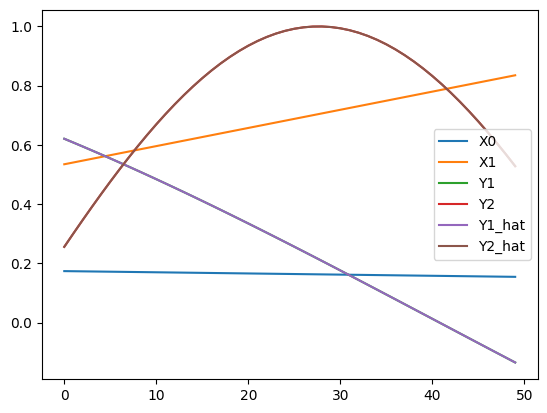

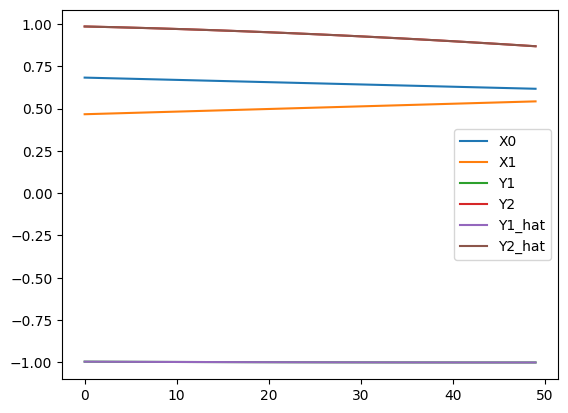

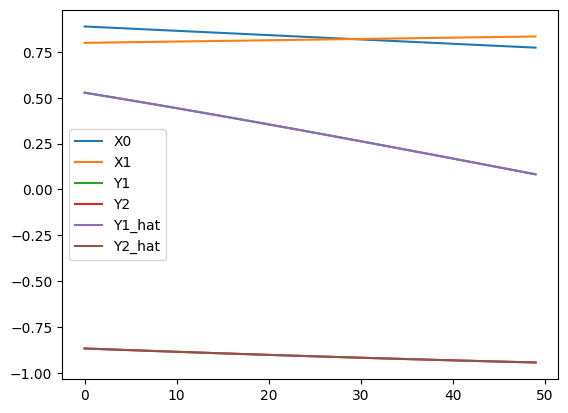

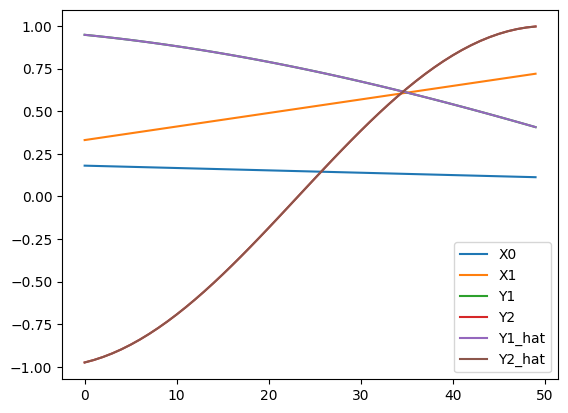

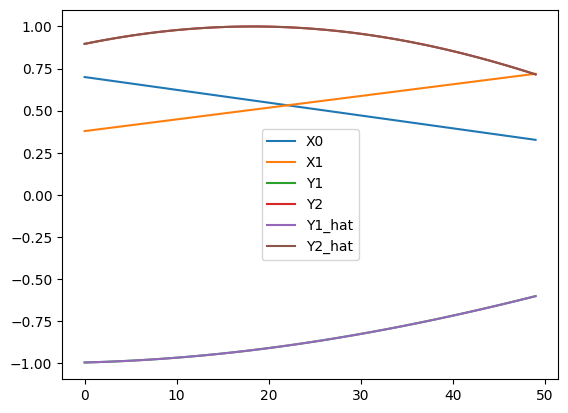

In [30]:
num_samples=5
plot_samples(num_samples, x1_x2, y1_y2)

In [31]:
num_samples = 5
for batch in train_loader:
    x1_x2, y1_y2 = batch 
    y_givens = y1_y2[:5,:,:,:]
    break

**Plot samples generated from untrained model**

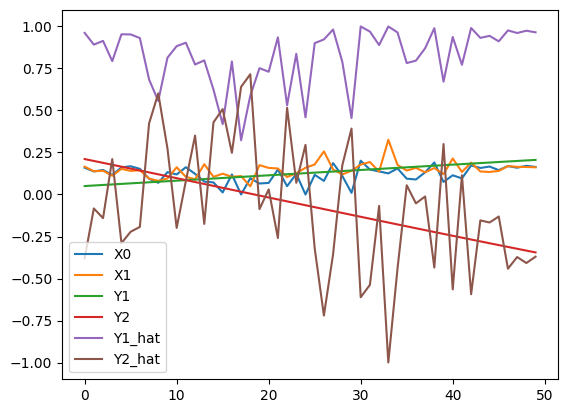

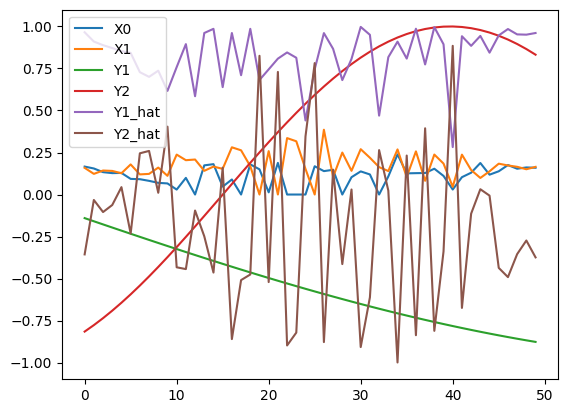

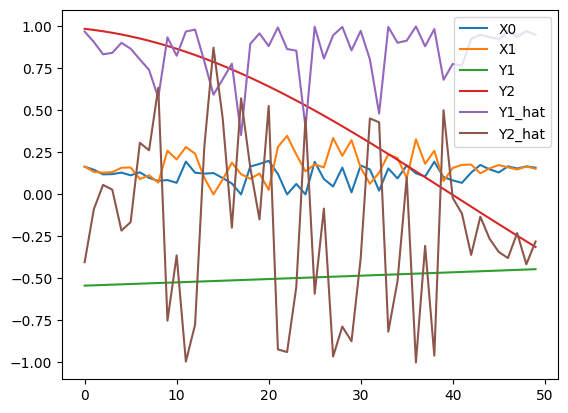

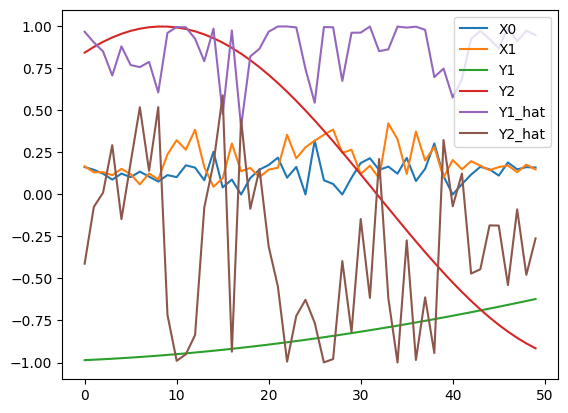

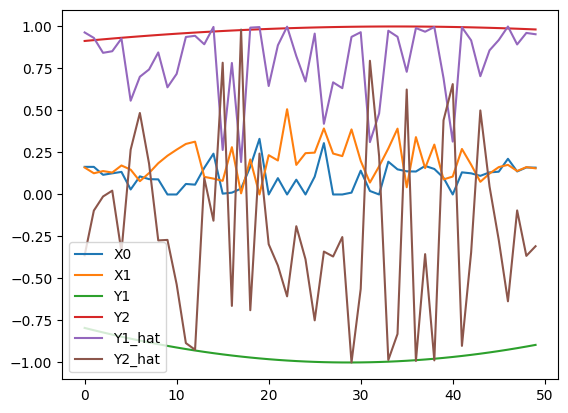

In [32]:
samples, givens = generate_samples(num_samples, y_givens)
plot_samples(num_samples, samples, givens)

# Setting up optimizer and learning rate scheduler

In [33]:
optimizer = torch.optim.Adam(Model.parameters(), lr=0.001)

In [34]:
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

# Model Training

In [35]:
loss_ = []

epochs = 40

for epoch in range(epochs):
    running_x_loss = 0
    running_y_loss = 0
    running_KLD = 0
    running_loss = 0
    
    for batch in tqdm(train_loader):
        x0_x1, y1_y2 = batch
        x0_x1 = x0_x1.to(device)
        y1_y2 = y1_y2.to(device)
        
        Model.train()  
        z_mu, z_log_var, x_hat = Model(x0_x1, y1_y2)
        
        
        x_loss, KLD, y_loss, loss = loss_function(x0_x1, x_hat, z_mu, z_log_var, y1_y2)
        x_loss, KLD, y_loss, loss = x_loss.to(device), KLD.to(device), y_loss.to(device), loss.to(device)
        
        running_loss += loss.item()
        running_y_loss += y_loss.item()
        running_x_loss += x_loss.item()
        running_KLD += KLD.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    running_KLD = running_KLD / len(train_loader)
    running_loss = running_loss / len(train_loader)
    running_y_loss = running_y_loss / len(train_loader)
    running_x_loss = running_x_loss / len(train_loader)
    scheduler.step()
    
    loss_.append(running_loss)
    
    print(f'{epoch + 1}/{epochs} Loss: {running_loss} KLD: {running_KLD} y_loss: {running_y_loss} x_loss: {running_x_loss}')


  0%|          | 0/3125 [00:00<?, ?it/s]

1/40 Loss: 0.4908209416484833 KLD: 0.016526777906417846 y_loss: 0.12483622904181481 x_loss: 0.34945793456554414


  0%|          | 0/3125 [00:00<?, ?it/s]

2/40 Loss: 0.3870627906322479 KLD: 0.00016678466796875 y_loss: 0.07265861555337906 x_loss: 0.31423739025592806


  0%|          | 0/3125 [00:00<?, ?it/s]

3/40 Loss: 0.3710198091697693 KLD: 0.00014742149353027344 y_loss: 0.06591941670894623 x_loss: 0.30495297065258026


  0%|          | 0/3125 [00:00<?, ?it/s]

4/40 Loss: 0.35999351987838746 KLD: 0.00015355172157287597 y_loss: 0.06328560688138007 x_loss: 0.29655436116695405


  0%|          | 0/3125 [00:00<?, ?it/s]

5/40 Loss: 0.32502360402584074 KLD: 0.000161546630859375 y_loss: 0.06828571393013 x_loss: 0.25657634349823


  0%|          | 0/3125 [00:00<?, ?it/s]

6/40 Loss: 0.24220497385978698 KLD: 0.0002378631591796875 y_loss: 0.07089272160887718 x_loss: 0.17107438910722733


  0%|          | 0/3125 [00:00<?, ?it/s]

7/40 Loss: 0.20427007855653762 KLD: 0.00018716094970703124 y_loss: 0.06331764895319938 x_loss: 0.14076526871681214


  0%|          | 0/3125 [00:00<?, ?it/s]

8/40 Loss: 0.18977732595443725 KLD: 0.000164083251953125 y_loss: 0.05666249663233757 x_loss: 0.13295074609041213


  0%|          | 0/3125 [00:00<?, ?it/s]

9/40 Loss: 0.17990748215198518 KLD: 0.000165540771484375 y_loss: 0.053019297356009486 x_loss: 0.12672264383673668


  0%|          | 0/3125 [00:00<?, ?it/s]

10/40 Loss: 0.17160060041904449 KLD: 0.00016015533447265624 y_loss: 0.050473242297172545 x_loss: 0.12096720273494721


  0%|          | 0/3125 [00:00<?, ?it/s]

11/40 Loss: 0.16224759754419327 KLD: 0.00015895355224609375 y_loss: 0.046263679637908936 x_loss: 0.11582496448755264


  0%|          | 0/3125 [00:00<?, ?it/s]

12/40 Loss: 0.15698613485097884 KLD: 0.00016010162353515624 y_loss: 0.04464641402602196 x_loss: 0.11217961935281753


  0%|          | 0/3125 [00:00<?, ?it/s]

13/40 Loss: 0.15408714003324508 KLD: 0.0001590350341796875 y_loss: 0.043365889906287196 x_loss: 0.11056221503257752


  0%|          | 0/3125 [00:00<?, ?it/s]

14/40 Loss: 0.15078590246915818 KLD: 0.000159229736328125 y_loss: 0.041998791285157204 x_loss: 0.108627881462574


  0%|          | 0/3125 [00:00<?, ?it/s]

15/40 Loss: 0.14836674896478652 KLD: 0.0001600946044921875 y_loss: 0.040964526000022886 x_loss: 0.1072421283364296


  0%|          | 0/3125 [00:00<?, ?it/s]

16/40 Loss: 0.1457083453989029 KLD: 0.00015875640869140626 y_loss: 0.039363377907276155 x_loss: 0.10618621104836463


  0%|          | 0/3125 [00:00<?, ?it/s]

17/40 Loss: 0.14475583203077316 KLD: 0.00016175445556640625 y_loss: 0.038956545670032504 x_loss: 0.1056375318813324


  0%|          | 0/3125 [00:00<?, ?it/s]

18/40 Loss: 0.14310215359687806 KLD: 0.00015980743408203126 y_loss: 0.03819058934986591 x_loss: 0.10475175677418709


  0%|          | 0/3125 [00:00<?, ?it/s]

19/40 Loss: 0.14106842786073684 KLD: 0.00015978424072265625 y_loss: 0.03693582149207592 x_loss: 0.10397282215714454


  0%|          | 0/3125 [00:00<?, ?it/s]

20/40 Loss: 0.14031454984426497 KLD: 0.00015907806396484375 y_loss: 0.036777411081790924 x_loss: 0.10337806065678597


  0%|          | 0/3125 [00:00<?, ?it/s]

21/40 Loss: 0.13617423131227493 KLD: 0.000153695068359375 y_loss: 0.034531362907886505 x_loss: 0.1014891733777523


  0%|          | 0/3125 [00:00<?, ?it/s]

22/40 Loss: 0.1350655972123146 KLD: 0.000153431396484375 y_loss: 0.03408602612912655 x_loss: 0.10082613968372345


  0%|          | 0/3125 [00:00<?, ?it/s]

23/40 Loss: 0.13431164993524553 KLD: 0.000157430419921875 y_loss: 0.03375172439813614 x_loss: 0.10040249509096145


  0%|          | 0/3125 [00:00<?, ?it/s]

24/40 Loss: 0.13273852672100067 KLD: 0.000153194580078125 y_loss: 0.03309108191013336 x_loss: 0.09949425021171569


  0%|          | 0/3125 [00:00<?, ?it/s]

25/40 Loss: 0.131972098133564 KLD: 0.00014933837890625 y_loss: 0.03254113921701908 x_loss: 0.09928162053942681


  0%|          | 0/3125 [00:00<?, ?it/s]

26/40 Loss: 0.13074706262111663 KLD: 0.00015343414306640625 y_loss: 0.03195200928032398 x_loss: 0.09864161924242973


  0%|          | 0/3125 [00:00<?, ?it/s]

27/40 Loss: 0.1300716984438896 KLD: 0.00015085052490234374 y_loss: 0.03148330034613609 x_loss: 0.09843754751324654


  0%|          | 0/3125 [00:00<?, ?it/s]

28/40 Loss: 0.12893398883342744 KLD: 0.00014707794189453124 y_loss: 0.031218016205430032 x_loss: 0.09756889472484588


  0%|          | 0/3125 [00:00<?, ?it/s]

29/40 Loss: 0.1285213452911377 KLD: 0.000146473388671875 y_loss: 0.03097017288506031 x_loss: 0.0974046990954876


  0%|          | 0/3125 [00:00<?, ?it/s]

30/40 Loss: 0.1278200241661072 KLD: 0.0001471142578125 y_loss: 0.030629496884942056 x_loss: 0.0970434130346775


  0%|          | 0/3125 [00:00<?, ?it/s]

31/40 Loss: 0.12515521586418152 KLD: 0.00014219940185546874 y_loss: 0.029147374992966654 x_loss: 0.09586564151525498


  0%|          | 0/3125 [00:00<?, ?it/s]

32/40 Loss: 0.1247673974275589 KLD: 0.00014985931396484375 y_loss: 0.029178730210661887 x_loss: 0.09543880790948868


  0%|          | 0/3125 [00:00<?, ?it/s]

33/40 Loss: 0.12428120002508164 KLD: 0.0001387115478515625 y_loss: 0.02847742961704731 x_loss: 0.09566505890369416


  0%|          | 0/3125 [00:00<?, ?it/s]

34/40 Loss: 0.12375680082559586 KLD: 0.00013920196533203125 y_loss: 0.02831513212442398 x_loss: 0.09530246671438217


  0%|          | 0/3125 [00:00<?, ?it/s]

35/40 Loss: 0.12309714655518532 KLD: 0.0001449786376953125 y_loss: 0.02818982595205307 x_loss: 0.09476234195828438


  0%|          | 0/3125 [00:00<?, ?it/s]

36/40 Loss: 0.1225467322576046 KLD: 0.00013339202880859375 y_loss: 0.027854399417042732 x_loss: 0.09455894070863724


  0%|          | 0/3125 [00:00<?, ?it/s]

37/40 Loss: 0.1226376838707924 KLD: 0.0001362725830078125 y_loss: 0.02805239609479904 x_loss: 0.09444901510357857


  0%|          | 0/3125 [00:00<?, ?it/s]

38/40 Loss: 0.12224906000375747 KLD: 0.00013597503662109376 y_loss: 0.027649175323843957 x_loss: 0.09446390966176987


  0%|          | 0/3125 [00:00<?, ?it/s]

39/40 Loss: 0.12159369572639465 KLD: 0.00013325103759765625 y_loss: 0.027346648437678815 x_loss: 0.09411379619598388


  0%|          | 0/3125 [00:00<?, ?it/s]

40/40 Loss: 0.12145931523561478 KLD: 0.0001350616455078125 y_loss: 0.02723086451470852 x_loss: 0.09409338905096054


# Plotting some samples after training

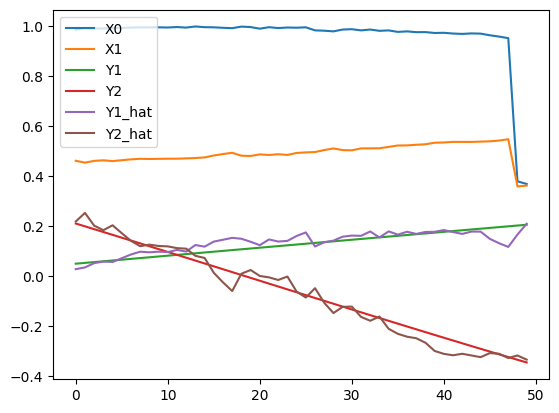

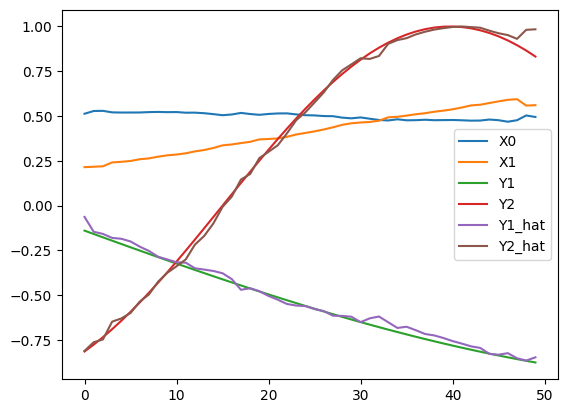

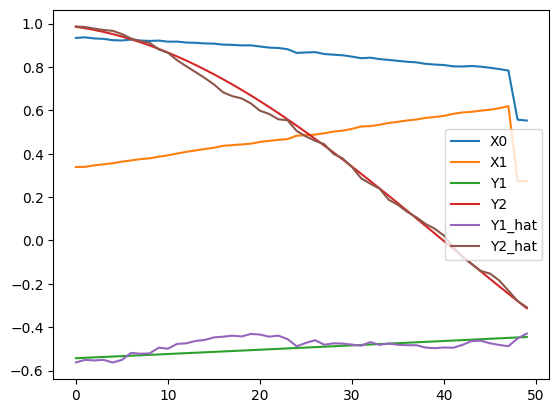

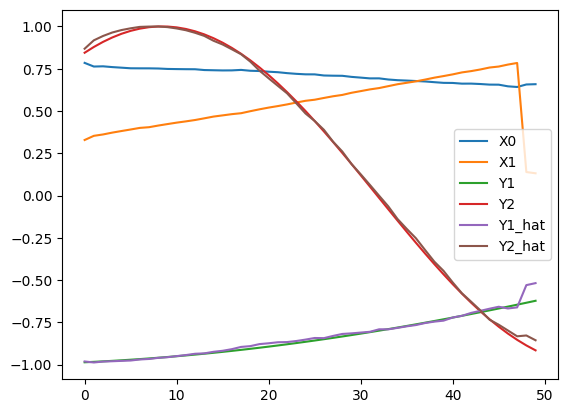

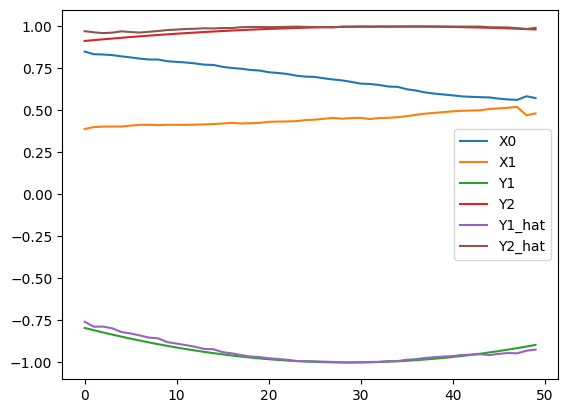

In [36]:
num_samples = 5
samples, givens = generate_samples(num_samples, y_givens)
plot_samples(num_samples, samples, givens)

# Validating the Model

In [38]:
val = torch.load("/kaggle/input/bh-data-1/validation_dataset.pt")

In [39]:
features, labels = val.tensors
features.shape, labels.shape

(torch.Size([3000, 1, 50, 2]), torch.Size([3000, 1, 50, 2]))

In [40]:
Val_Dataset = TensorDataset(features, labels)
val_loader = DataLoader(Val_Dataset, batch_size=batch_size, shuffle=True)

In [42]:
with torch.no_grad():
    
    Model.eval()
    val_x_loss = 0
    val_y_loss = 0
    val_KLD = 0
    val_loss = 0
    
    for batch in tqdm(val_loader):
        x0_x1, y1_y2 = batch
        x0_x1 = x0_x1.to(device)
        y1_y2 = y1_y2.to(device)
        
        z_mu, z_log_var, x_hat = Model(x0_x1, y1_y2)
        
        
        x_loss, KLD, y_loss, loss = loss_function(x0_x1, x_hat, z_mu, z_log_var, y1_y2)
        x_loss, KLD, y_loss, loss = x_loss.to(device), KLD.to(device), y_loss.to(device), loss.to(device)
        
        val_x_loss += x_loss.item()
        val_y_loss += y_loss.item()
        val_KLD += KLD.item()
        val_loss += loss.item()
        
val_x_loss /= len(val_loader)
val_y_loss /= len(val_loader)
val_KLD /= len(val_loader)
val_loss /= len(val_loader)
print(f'Loss: {val_loss} KLD: {val_KLD} y_loss: {val_y_loss} x_loss: {val_x_loss}')

  0%|          | 0/94 [00:00<?, ?it/s]

Loss: 0.11956086992583376 KLD: 0.00012650134715628118 y_loss: 0.026122560288677824 x_loss: 0.09331180860704565


# Creating Samples for Submission

In [43]:
score = torch.load("/kaggle/input/bh-data-1/scoring_dataset.pt")

In [44]:
x_sc, y_sc = score.tensors
x_sc.shape, y_sc.shape

(torch.Size([50, 1, 50, 2]), torch.Size([50, 1, 50, 2]))

In [45]:
Model.eval()
x0_x1 = torch.tensor([])
x0_x1 = x0_x1.to(device)
y1_y2 = torch.tensor([])
y1_y2 = y1_y2.to(device)

for i in range(50):
    x_sc_1, y_sc_1 = x_sc[i,:,:,:],y_sc[i,:,:,:]
    x_sc_1 = torch.unsqueeze(x_sc_1, dim=0)
    y_sc_1 = torch.unsqueeze(y_sc_1, dim=0)
    
    x_sc_1 = x_sc_1.to(device)
    y_sc_1 = y_sc_1.to(device)
    for j in range(30):
        z_rand = torch.randn(1, 50, 2)
        z_rand = z_rand.to(device)
        z_mu, z_log_var = Model.encoder(torch.unsqueeze(z_rand, dim=0), y_sc_1)
        z = Model.sampling(z_mu, z_log_var) 
        
        sample = Model.decoder(z, y_sc_1)
    
        x0_x1 = torch.cat([sample, x0_x1], dim=0)
        y1_y2 = torch.cat([y1_y2, y_sc_1], dim=0)

In [47]:
x0_x1 = x0_x1.to("cpu")
y1_y2 = y1_y2.to("cpu")

In [48]:
ouput = TensorDataset(x0_x1, y1_y2)

In [49]:
torch.save(ouput,"result_data_1.pt")